# Timeseries Forecasting

This notebook explains how to use `tsfresh` in time series foreacasting.
Make sure you also read through the [documentation](https://tsfresh.readthedocs.io/en/latest/text/forecasting.html) to learn more on this feature.

We will use the stock price of Apple for this.
In this notebook we will only showcase how to work with a single time series at a time (one stock).
There exist another notebook in the `advanced` folder, which treats several stocks at the same time.
Basically the same - but a bit more complex when it comes to pandas multi-indexing.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

try:
    import pandas_datareader.data as web
except ImportError:
    print("You need to install the pandas_datareader. Run pip install pandas_datareader.")

from sklearn.linear_model import LinearRegression

## Reading the data

We download the data from "stooq" and only store the High value.
Please note: this notebook is for showcasing `tsfresh`s feature extraction - not to predict stock market prices :-)

In [62]:
df = web.DataReader("AAPL", 'stooq')["High"]
df

Date
2026-02-13    262.230
2026-02-12    275.720
2026-02-11    280.180
2026-02-10    275.370
2026-02-09    278.200
               ...   
2021-02-24    122.416
2021-02-23    123.544
2021-02-22    126.468
2021-02-19    127.423
2021-02-18    126.735
Name: High, Length: 1254, dtype: float64

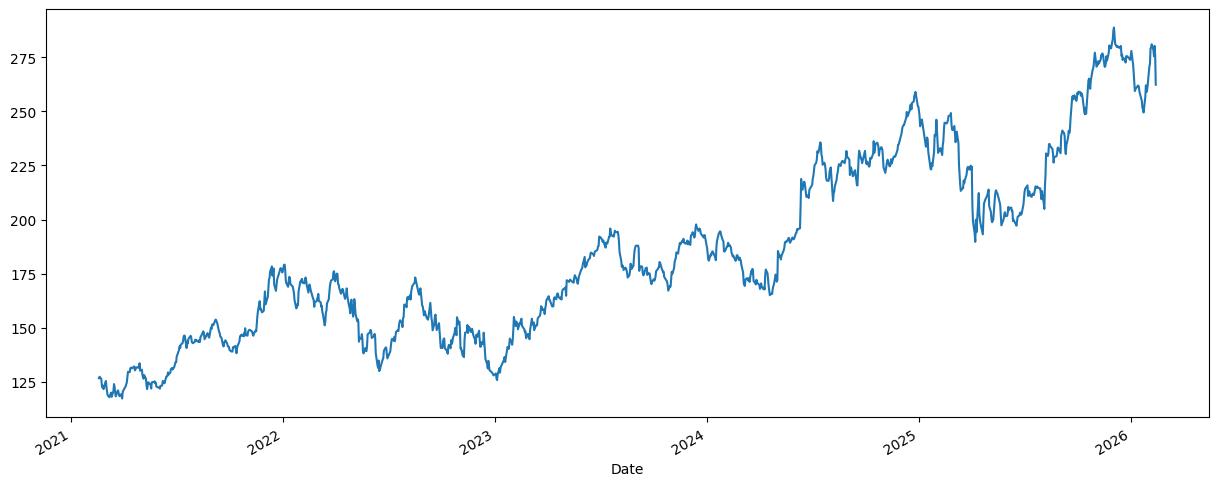

In [63]:
plt.figure(figsize=(15, 6))
df.plot(ax=plt.gca())
plt.show()

We want to make the time dependency a bit clearer and add an identifier to each of the stock values (in this notebook we only have Google though).

In [64]:
df_melted = pd.DataFrame({"high": df.copy()})
df_melted["date"] = df_melted.index
df_melted["Symbols"] = "AAPL"

df_melted

,high,date,Symbols
Date,,,
2026-02-13,262.230,2026-02-13,AAPL
2026-02-12,275.720,2026-02-12,AAPL
2026-02-11,280.180,2026-02-11,AAPL
2026-02-10,275.370,2026-02-10,AAPL
2026-02-09,278.200,2026-02-09,AAPL
...,...,...,...
2021-02-24,122.416,2021-02-24,AAPL
2021-02-23,123.544,2021-02-23,AAPL
2021-02-22,126.468,2021-02-22,AAPL


## Create training data sample

Forecasting typically involves the following steps:
* take all data up to today
* do feature extraction (e.g. by running `extract_features`)
* run a prediction model (e.g. a regressor, see below)
* use the result as the forecast for tomorrow

In training however, we need multiple examples to train.
If we would only use the time series until today (and wait for the value of tomorrow to have a target), we would only have a single training example.
Therefore we use a trick: we replay the history.

Imagine you have a cut-out window sliding over your data.
At each time step $t$, you treat the data as it would be today. 
You extract the features with everything you know until today (which is all data until and including $t$).
The target for the features until time $t$ is the time value of time $t + 1$ (which you already know, because everything has already happened).

The process of window-sliding is implemented in the function `roll_time_series`.
Our window size will be 20 (we look at max 20 days in the past) and we disregard all windows which are shorter than 5 days.

In [65]:
df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="date",
                             max_timeshift=20, min_timeshift=5)

d:\GIT\m4-feature-importance-main-clone\mt_env\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 49/49 [00:03<00:00, 12.73it/s]


In [66]:
df_rolled

,high,date,Symbols,id
0,126.735,2021-02-18,AAPL,"(AAPL, 2021-02-25 00:00:00)"
1,127.423,2021-02-19,AAPL,"(AAPL, 2021-02-25 00:00:00)"
2,126.468,2021-02-22,AAPL,"(AAPL, 2021-02-25 00:00:00)"
3,123.544,2021-02-23,AAPL,"(AAPL, 2021-02-25 00:00:00)"
4,122.416,2021-02-24,AAPL,"(AAPL, 2021-02-25 00:00:00)"
...,...,...,...,...
24466,278.200,2026-02-09,AAPL,"(AAPL, 2026-02-13 00:00:00)"
24467,275.370,2026-02-10,AAPL,"(AAPL, 2026-02-13 00:00:00)"
24468,280.180,2026-02-11,AAPL,"(AAPL, 2026-02-13 00:00:00)"
24469,275.720,2026-02-12,AAPL,"(AAPL, 2026-02-13 00:00:00)"


The resulting dataframe now consists of these "windows" stamped out of the original dataframe.
For example all data with the `id = (AAPL, 2026-02-10 00:00:00)` comes from the original data of stock `AAPL` including the last 20 days until `2026-02-10`:

In [67]:
df_rolled[df_rolled["id"] == ("AAPL", pd.to_datetime("2026-02-10"))]

,high,date,Symbols,id
24387,261.3000,2026-01-12,AAPL,"(AAPL, 2026-02-10 00:00:00)"
24388,261.8100,2026-01-13,AAPL,"(AAPL, 2026-02-10 00:00:00)"
24389,261.8200,2026-01-14,AAPL,"(AAPL, 2026-02-10 00:00:00)"
24390,261.0400,2026-01-15,AAPL,"(AAPL, 2026-02-10 00:00:00)"
24391,258.9000,2026-01-16,AAPL,"(AAPL, 2026-02-10 00:00:00)"
24392,254.7900,2026-01-20,AAPL,"(AAPL, 2026-02-10 00:00:00)"
24393,251.5600,2026-01-21,AAPL,"(AAPL, 2026-02-10 00:00:00)"
24394,251.0000,2026-01-22,AAPL,"(AAPL, 2026-02-10 00:00:00)"
24395,249.4100,2026-01-23,AAPL,"(AAPL, 2026-02-10 00:00:00)"
24396,256.5600,2026-01-26,AAPL,"(AAPL, 2026-02-10 00:00:00)"


In [68]:
df_melted[(df_melted["date"] <= pd.to_datetime("2026-02-10")) & 
          (df_melted["date"] >= pd.to_datetime("2026-01-10")) & 
          (df_melted["Symbols"] == "AAPL")]

,high,date,Symbols
Date,,,
2026-02-10,275.3700,2026-02-10,AAPL
2026-02-09,278.2000,2026-02-09,AAPL
2026-02-06,280.9050,2026-02-06,AAPL
2026-02-05,279.5000,2026-02-05,AAPL
2026-02-04,278.9500,2026-02-04,AAPL
2026-02-03,271.8750,2026-02-03,AAPL
2026-02-02,270.4900,2026-02-02,AAPL
2026-01-30,261.8999,2026-01-30,AAPL
2026-01-29,259.6500,2026-01-29,AAPL


If you now group by the new `id` column, each of the groups will be a certain stock symbol until and including the data until a certain day (and including the last 20 days in the past).

Whereas we started with 1257 data samples:

In [69]:
len(df_melted)

1254

we now have 1253 unique windows (identified by stock symbol and ending date):

In [70]:
df_rolled["id"].nunique()

1249

We "lost" 5 windows, as we required to have a minimum history of more than 5 days.

In [71]:
df_rolled.groupby("id").size().agg(["min", "max"])

min     6
max    21
dtype: int64

The process is also shown in this image (please note that the window size is smaller for better visibility):

<img src="./stocks.png"/>

## Extract Features

The rolled (windowed) data sample is now in the correct format to use it for `tsfresh`s feature extraction.
As normal, features will be extracted using all data for a given `id`, which is in our case all data of a given window and a given id (one colored box in the graph above).

If the feature extraction returns a row with the index `(AAPL, 2026-02-10 00:00:00)`, you know it has been calculated using the `AAPL` data up and including `2026-02-10` (and 20 days of history).

In [ ]:
X = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="date", column_value="high", 
                     impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


In [73]:
X

high__variance_larger_than_standard_deviation  \
AAPL 2021-02-25                                            1.0   
     2021-02-26                                            1.0   
     2021-03-01                                            1.0   
     2021-03-02                                            1.0   
     2021-03-03                                            1.0   
...                                                        ...   
     2026-02-09                                            1.0   
     2026-02-10                                            1.0   
     2026-02-11                                            1.0   
     2026-02-12                                            1.0   
     2026-02-13                                            1.0   

                 high__has_duplicate_max  high__has_duplicate_min  \
AAPL 2021-02-25                      0.0                      0.0   
     2021-02-26                      0.0                      0.0   
     2021-03-01                      0.0                      0.0   
     2021-03-02                      0.0                      0.0   
     2021-03-03                      0.0                      0.0   
...                                  ...                      ...   
     2026-02-09                      0.0                      0.0   
     2026-02-10                      0.0                      0.0   
     2026-02-11                      0.0                      0.0   
     2026-02-12                      0.0                      0.0   
     2026-02-13                      0.0                      0.0   

                 high__has_duplicate  high__sum_values  high__abs_energy  \
AAPL 2021-02-25                  0.0          749.8730      9.374102e+04   
     2021-02-26                  0.0          871.5900      1.085560e+05   
     2021-03-01                  0.0          996.3020      1.241091e+05   
     2021-03-02                  0.0         1121.7910      1.398566e+05   
     2021-03-03                  0.0         1244.3530      1.548781e+05   
...                              ...               ...               ...   
     2026-02-09                  0.0         5530.6749      1.458432e+06   
     2026-02-10                  0.0         5545.8349      1.466552e+06   
     2026-02-11                  0.0         5564.7149      1.476775e+06   
     2026-02-12                  0.0         5578.6249      1.484252e+06   
     2026-02-13                  0.0         5579.0349      1.484467e+06   

                 high__mean_abs_change  high__mean_change  \
AAPL 2021-02-25               1.313200          -0.689600   
     2021-02-26               1.356000          -0.836333   
     2021-03-01               1.590143          -0.289000   
     2021-03-02               1.488500          -0.155750   
     2021-03-03               1.648333          -0.463667   
...                                ...                ...   
     2026-02-09               2.720500           0.899500   
     2026-02-10               2.807500           0.703500   
     2026-02-11               3.022500           0.918500   
     2026-02-12               3.245000           0.695000   
     2026-02-13               3.880500           0.059500   

                 high__mean_second_derivative_central  high__median  ...  \
AAPL 2021-02-25                              0.022875      125.0060  ...   
     2021-02-26                             -0.225800      123.5440  ...   
     2021-03-01                              0.192250      124.1280  ...   
     2021-03-02                              0.006357      124.7120  ...   
     2021-03-03                             -0.225938      124.1280  ...   
...                                               ...           ...  ...   
     2026-02-09                             -0.099868      261.3000  ...   
     2026-02-10                             -0.087895      261.8100  ...   
     2026-02-11                              0.126316      261.82

We make the data a bit easier to work with by removing the tuple-index

In [74]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"
X

,high__variance_larger_than_standard_deviation,high__has_duplicate_max,high__has_duplicate_min,high__has_duplicate,high__sum_values,high__abs_energy,high__mean_abs_change,high__mean_change,high__mean_second_derivative_central,high__median,...,high__fourier_entropy__bins_5,high__fourier_entropy__bins_10,high__fourier_entropy__bins_100,high__permutation_entropy__dimension_3__tau_1,high__permutation_entropy__dimension_4__tau_1,high__permutation_entropy__dimension_5__tau_1,high__permutation_entropy__dimension_6__tau_1,high__permutation_entropy__dimension_7__tau_1,high__query_similarity_count__query_None__threshold_0.0,high__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,
2021-02-25,1.0,0.0,0.0,0.0,749.8730,9.374102e+04,1.313200,-0.689600,0.022875,125.0060,...,1.039721,1.386294,1.386294,1.039721,1.098612,0.693147,-0.000000,2.708050,0.0,178.757857
2021-02-26,1.0,0.0,0.0,0.0,871.5900,1.085560e+05,1.356000,-0.836333,-0.225800,123.5440,...,1.039721,1.386294,1.386294,1.054920,1.386294,1.098612,0.693147,-0.000000,0.0,178.757857
2021-03-01,1.0,0.0,0.0,0.0,996.3020,1.241091e+05,1.590143,-0.289000,0.192250,124.1280,...,0.950271,1.332179,1.609438,1.329661,1.609438,1.386294,1.098612,0.693147,0.0,124.940714
2021-03-02,1.0,0.0,0.0,0.0,1121.7910,1.398566e+05,1.488500,-0.155750,0.006357,124.7120,...,0.950271,0.950271,1.609438,1.549826,1.791759,1.609438,1.386294,1.098612,0.0,125.379714
2021-03-03,1.0,0.0,0.0,0.0,1244.3530,1.548781e+05,1.648333,-0.463667,-0.225938,124.1280,...,1.011404,1.329661,1.791759,1.494175,1.945910,1.791759,1.609438,1.386294,0.0,125.379714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-09,1.0,0.0,0.0,0.0,5530.6749,1.458432e+06,2.720500,0.899500,-0.099868,261.3000,...,0.600166,0.885574,1.767761,1.407149,1.908037,2.231607,2.479956,2.615631,0.0,274.552857
2026-02-10,1.0,0.0,0.0,0.0,5545.8349,1.466552e+06,2.807500,0.703500,-0.087895,261.8100,...,0.304636,0.759547,1.893788,1.430103,1.981208,2.231607,2.479956,2.615631,0.0,276.470000
2026-02-11,1.0,0.0,0.0,0.0,5564.7149,1.476775e+06,3.022500,0.918500,0.126316,261.8200,...,0.304636,0.600166,1.641735,1.515780,2.058224,2.313154,2.479956,2.615631,0.0,277.854286


Our `(AAPL, 2026-02-10 00:00:00)` is also in the data again:

In [75]:
X.loc['2026-02-10']

high__variance_larger_than_standard_deviation                 1.000000
high__has_duplicate_max                                       0.000000
high__has_duplicate_min                                       0.000000
high__has_duplicate                                           0.000000
high__sum_values                                           5545.834900
                                                              ...     
high__permutation_entropy__dimension_5__tau_1                 2.231607
high__permutation_entropy__dimension_6__tau_1                 2.479956
high__permutation_entropy__dimension_7__tau_1                 2.615631
high__query_similarity_count__query_None__threshold_0.0       0.000000
high__mean_n_absolute_max__number_of_maxima_7               276.470000
Name: 2026-02-10 00:00:00, Length: 783, dtype: float64

Just to repeat: the features in this row were only calculated using the time series values of `AAPL` up to and including `2026-02-10` and the last 20 days.

## Prediction

We can now use the extracted features to train a regressor.
But what will be our targets?
The target for the row `2026-02-09` is the value on the next timestep (that would be `2026-02-10` in this case).

So all we need to do is go back to our original dataframe and take the stock value of tomorrow.
This is done with `shift`:

In [76]:
y = df_melted.set_index("date").sort_index().high.shift(-1)

Quick consistency test:

In [77]:
y["2026-02-09"], df["2026-02-10"]

(np.float64(275.37), np.float64(275.37))

However, we need to be a bit careful here: `X` is missing the first 5 dates (as our minimum window size was 5) and `y` is missing the last date (as there is nothing to predict on today).
So lets make sure we have a consistent view on the data.

In [78]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

We can now train normal AdaBoostRegressors to predict the next time step .
Let's split the data into a training and testing sample (but make sure to keep temporal consistency).
We take everything until 2020 as train data an the rest as test:

In [79]:
X[:"2025"]

,high__variance_larger_than_standard_deviation,high__has_duplicate_max,high__has_duplicate_min,high__has_duplicate,high__sum_values,high__abs_energy,high__mean_abs_change,high__mean_change,high__mean_second_derivative_central,high__median,...,high__fourier_entropy__bins_5,high__fourier_entropy__bins_10,high__fourier_entropy__bins_100,high__permutation_entropy__dimension_3__tau_1,high__permutation_entropy__dimension_4__tau_1,high__permutation_entropy__dimension_5__tau_1,high__permutation_entropy__dimension_6__tau_1,high__permutation_entropy__dimension_7__tau_1,high__query_similarity_count__query_None__threshold_0.0,high__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,
2021-02-25,1.0,0.0,0.0,0.0,749.873,9.374102e+04,1.313200,-0.689600,0.022875,125.006,...,1.039721,1.386294,1.386294,1.039721,1.098612,0.693147,-0.000000,2.708050,0.0,178.757857
2021-02-26,1.0,0.0,0.0,0.0,871.590,1.085560e+05,1.356000,-0.836333,-0.225800,123.544,...,1.039721,1.386294,1.386294,1.054920,1.386294,1.098612,0.693147,-0.000000,0.0,178.757857
2021-03-01,1.0,0.0,0.0,0.0,996.302,1.241091e+05,1.590143,-0.289000,0.192250,124.128,...,0.950271,1.332179,1.609438,1.329661,1.609438,1.386294,1.098612,0.693147,0.0,124.940714
2021-03-02,1.0,0.0,0.0,0.0,1121.791,1.398566e+05,1.488500,-0.155750,0.006357,124.712,...,0.950271,0.950271,1.609438,1.549826,1.791759,1.609438,1.386294,1.098612,0.0,125.379714
2021-03-03,1.0,0.0,0.0,0.0,1244.353,1.548781e+05,1.648333,-0.463667,-0.225938,124.128,...,1.011404,1.329661,1.791759,1.494175,1.945910,1.791759,1.609438,1.386294,0.0,125.379714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-24,1.0,0.0,0.0,0.0,5864.329,1.638010e+06,1.794600,-0.247500,0.099474,279.590,...,0.600166,0.600166,1.672625,1.712299,2.399204,2.751667,2.772589,2.708050,0.0,283.691429
2025-12-26,1.0,0.0,0.0,0.0,5859.319,1.635226e+06,1.755100,-0.208000,0.012368,279.530,...,0.304636,0.600166,1.641735,1.754079,2.505290,2.751667,2.772589,2.708050,0.0,283.641429
2025-12-29,1.0,0.0,0.0,0.0,5854.149,1.632362e+06,1.779100,-0.232000,-0.142895,279.220,...,0.304636,0.600166,2.019815,1.712299,2.505290,2.751667,2.772589,2.708050,0.0,283.641429


In [87]:
X_train = X[:"2024"]
X_test = X["2025":]

y_train = y[:"2024"]
y_test = y["2025":]

and do feature selection before training

In [88]:
X_train_selected = select_features(X_train, y_train)

In [89]:
ada = LinearRegression()

ada.fit(X_train_selected, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Now lets check how good our prediction is:

In [90]:
X_test_selected = X_test[X_train_selected.columns]

y_pred = pd.Series(ada.predict(X_test_selected), index=X_test_selected.index)

The prediction is for the next day, so for drawing we need to shift 1 step back:

<Axes: xlabel='last_date'>

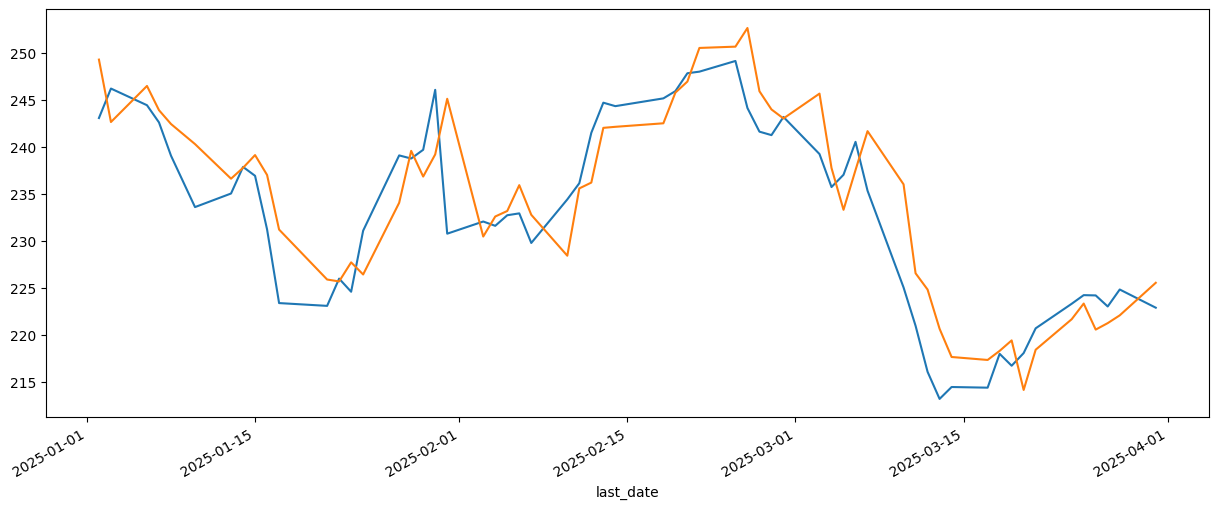

In [95]:
plt.figure(figsize=(15, 6))

y["2025-01":"2025-03"].plot(ax=plt.gca())
y_pred["2025-01":"2025-03"].plot(ax=plt.gca(), legend=None, marker=None)

Well, clearly not perfect ;-)